In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import numpy as np
import pandas as pd

cfg = yaml.load(open("outputs/2023-11-22/11-25-07/tabpfn_finetune-default-categorical_classification/config.yaml"), Loader=yaml.Loader)
plot_data = np.load("outputs/2023-11-22/11-25-07/tabpfn_finetune-default-categorical_classification/dataset_plot_separate.npy")
results = pd.read_csv("outputs/2023-11-22/11-25-07/tabpfn_finetune-default-categorical_classification/results.csv")

array([0.83825004, 0.83825004, 0.83825004, 0.83825004, 0.83825004,
       0.83825004, 0.83825004, 0.83825004, 0.83825004, 0.83825004])

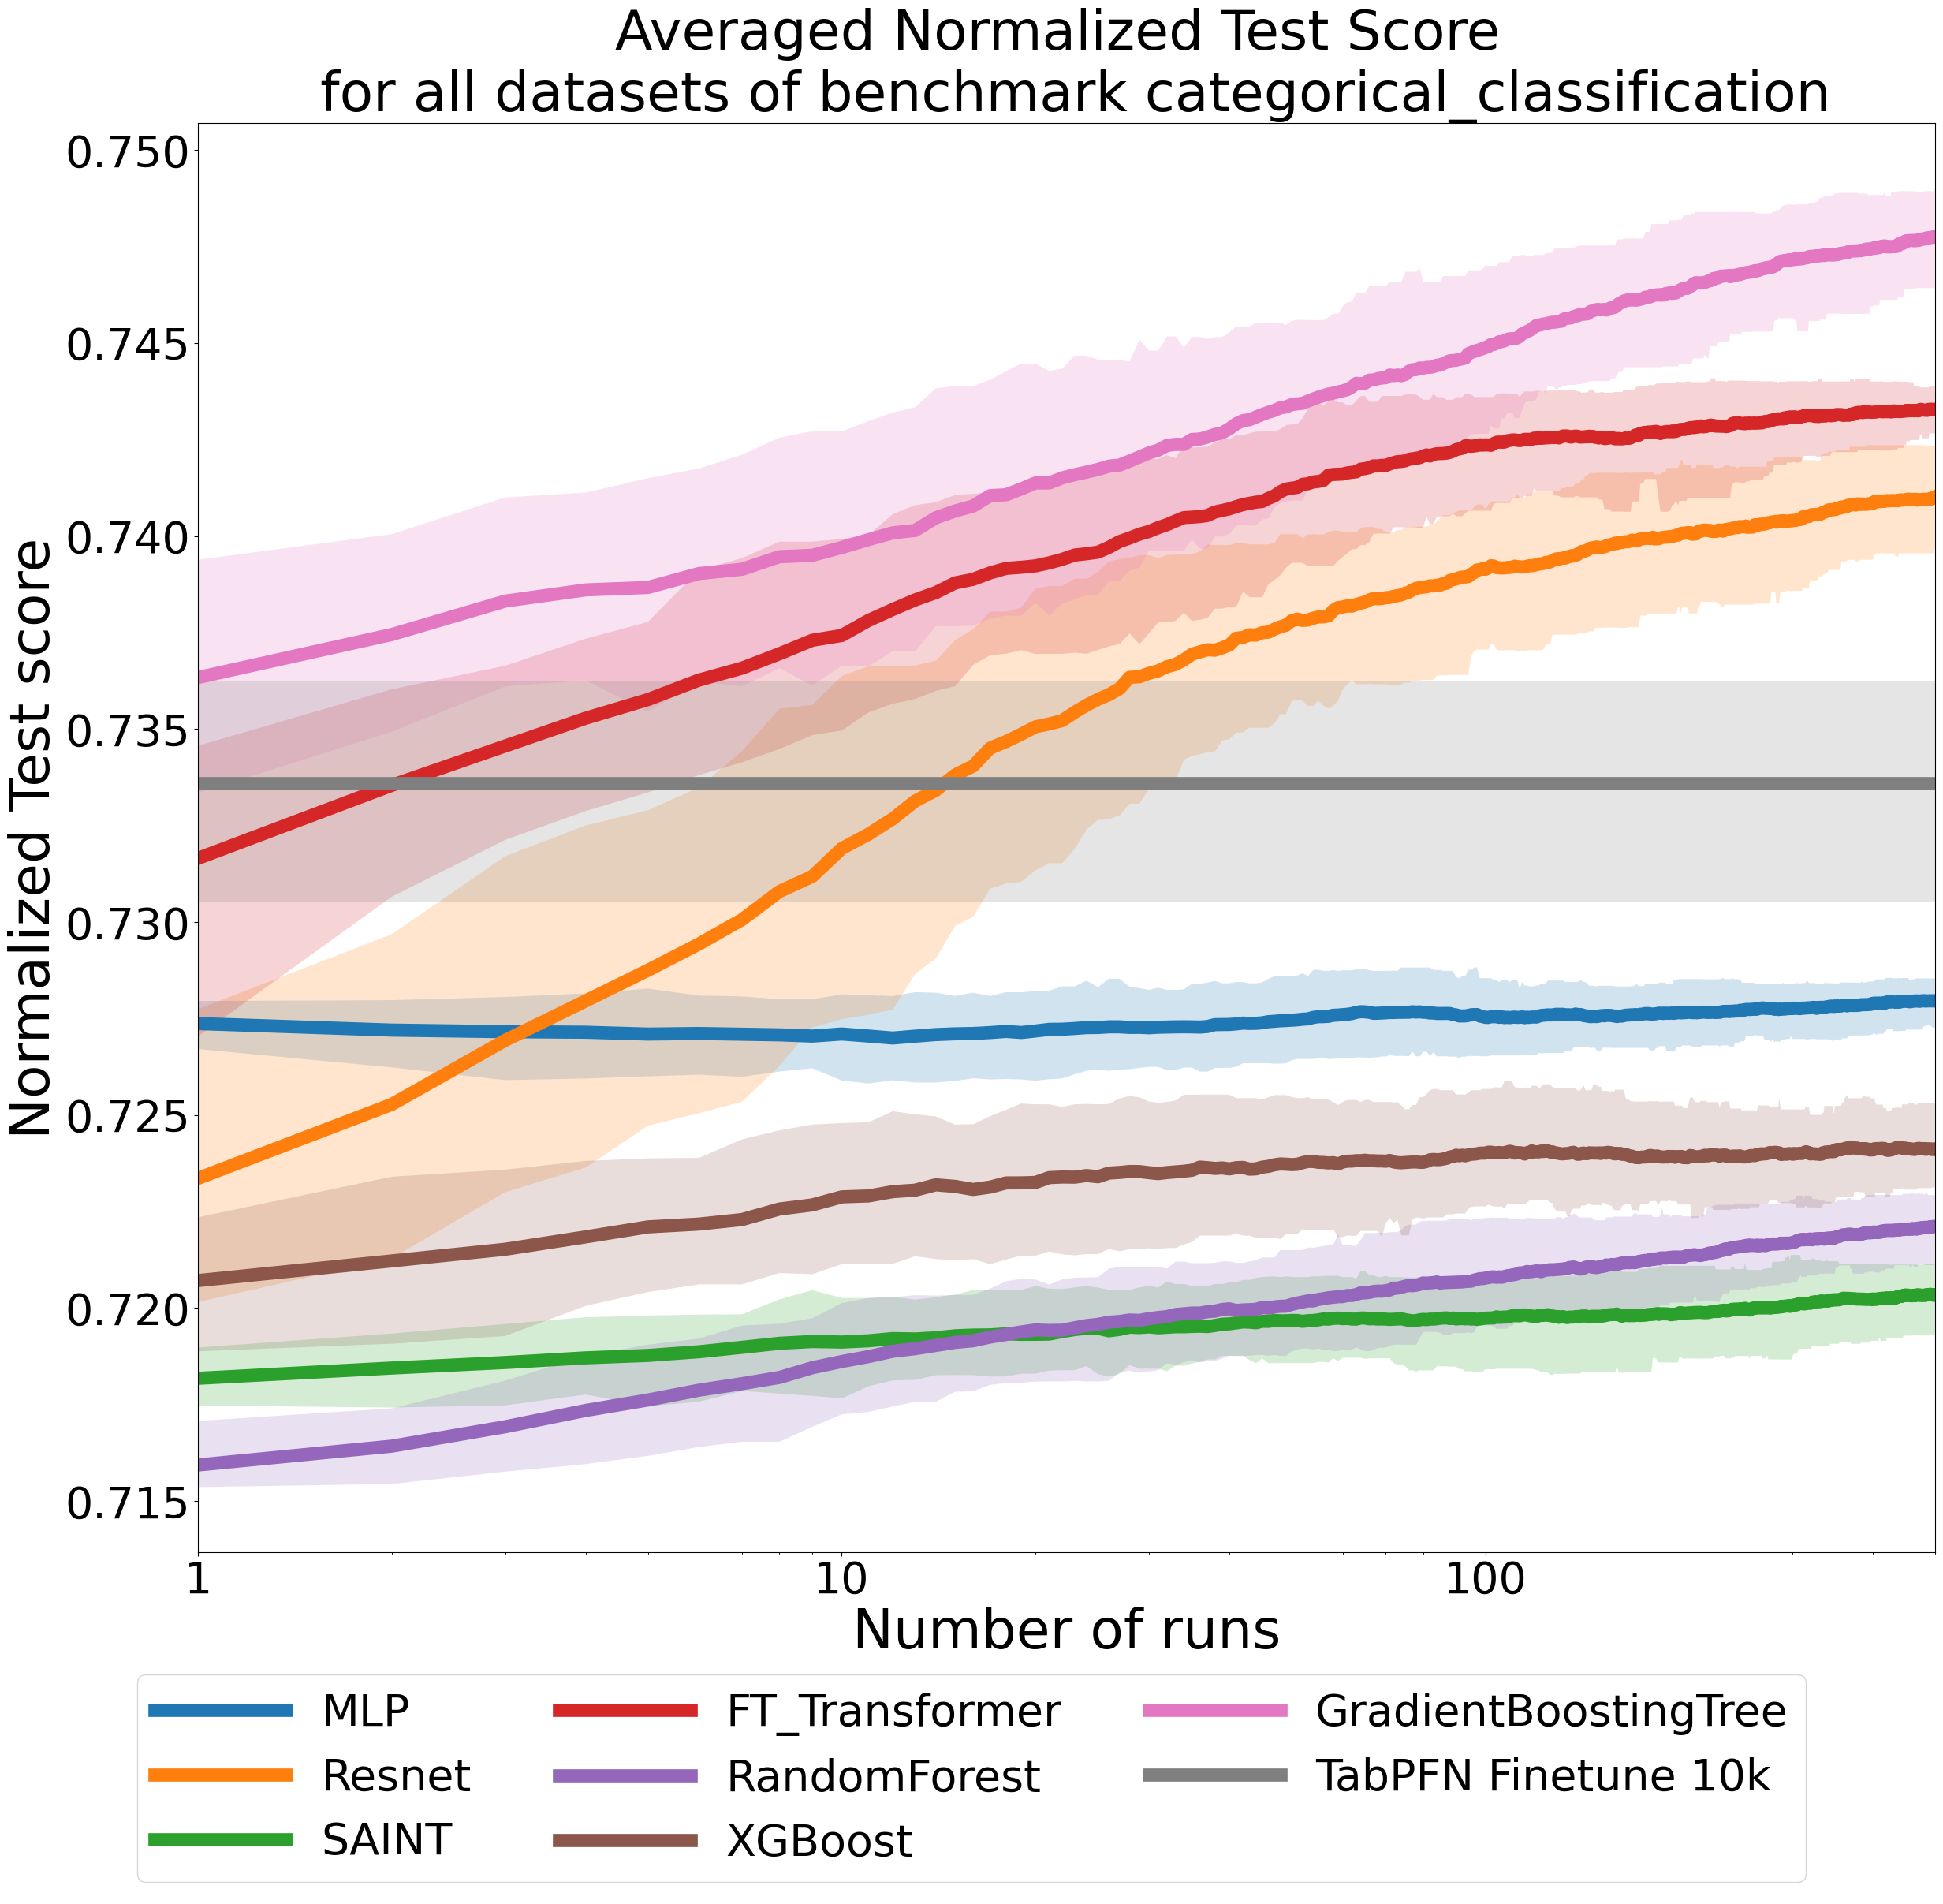

In [8]:
from tabularbench.results.dataset_plot import combine_and_process_run_results_with_benchmark
from tabularbench.results.dataset_plot_combined import make_combined_dataset_plot, make_combined_dataset_plot_data
from tabularbench.results.random_sequence import create_random_sequences_from_df
from tabularbench.results.reformat_benchmark import get_benchmark_csv_reformatted


df_bench = get_benchmark_csv_reformatted()
df_combined = combine_and_process_run_results_with_benchmark(cfg, results, df_bench)
sequences_all = create_random_sequences_from_df(cfg, df_combined)

plot_data_combined = make_combined_dataset_plot_data(cfg, sequences_all)
fig_combined = make_combined_dataset_plot(cfg, plot_data_combined)

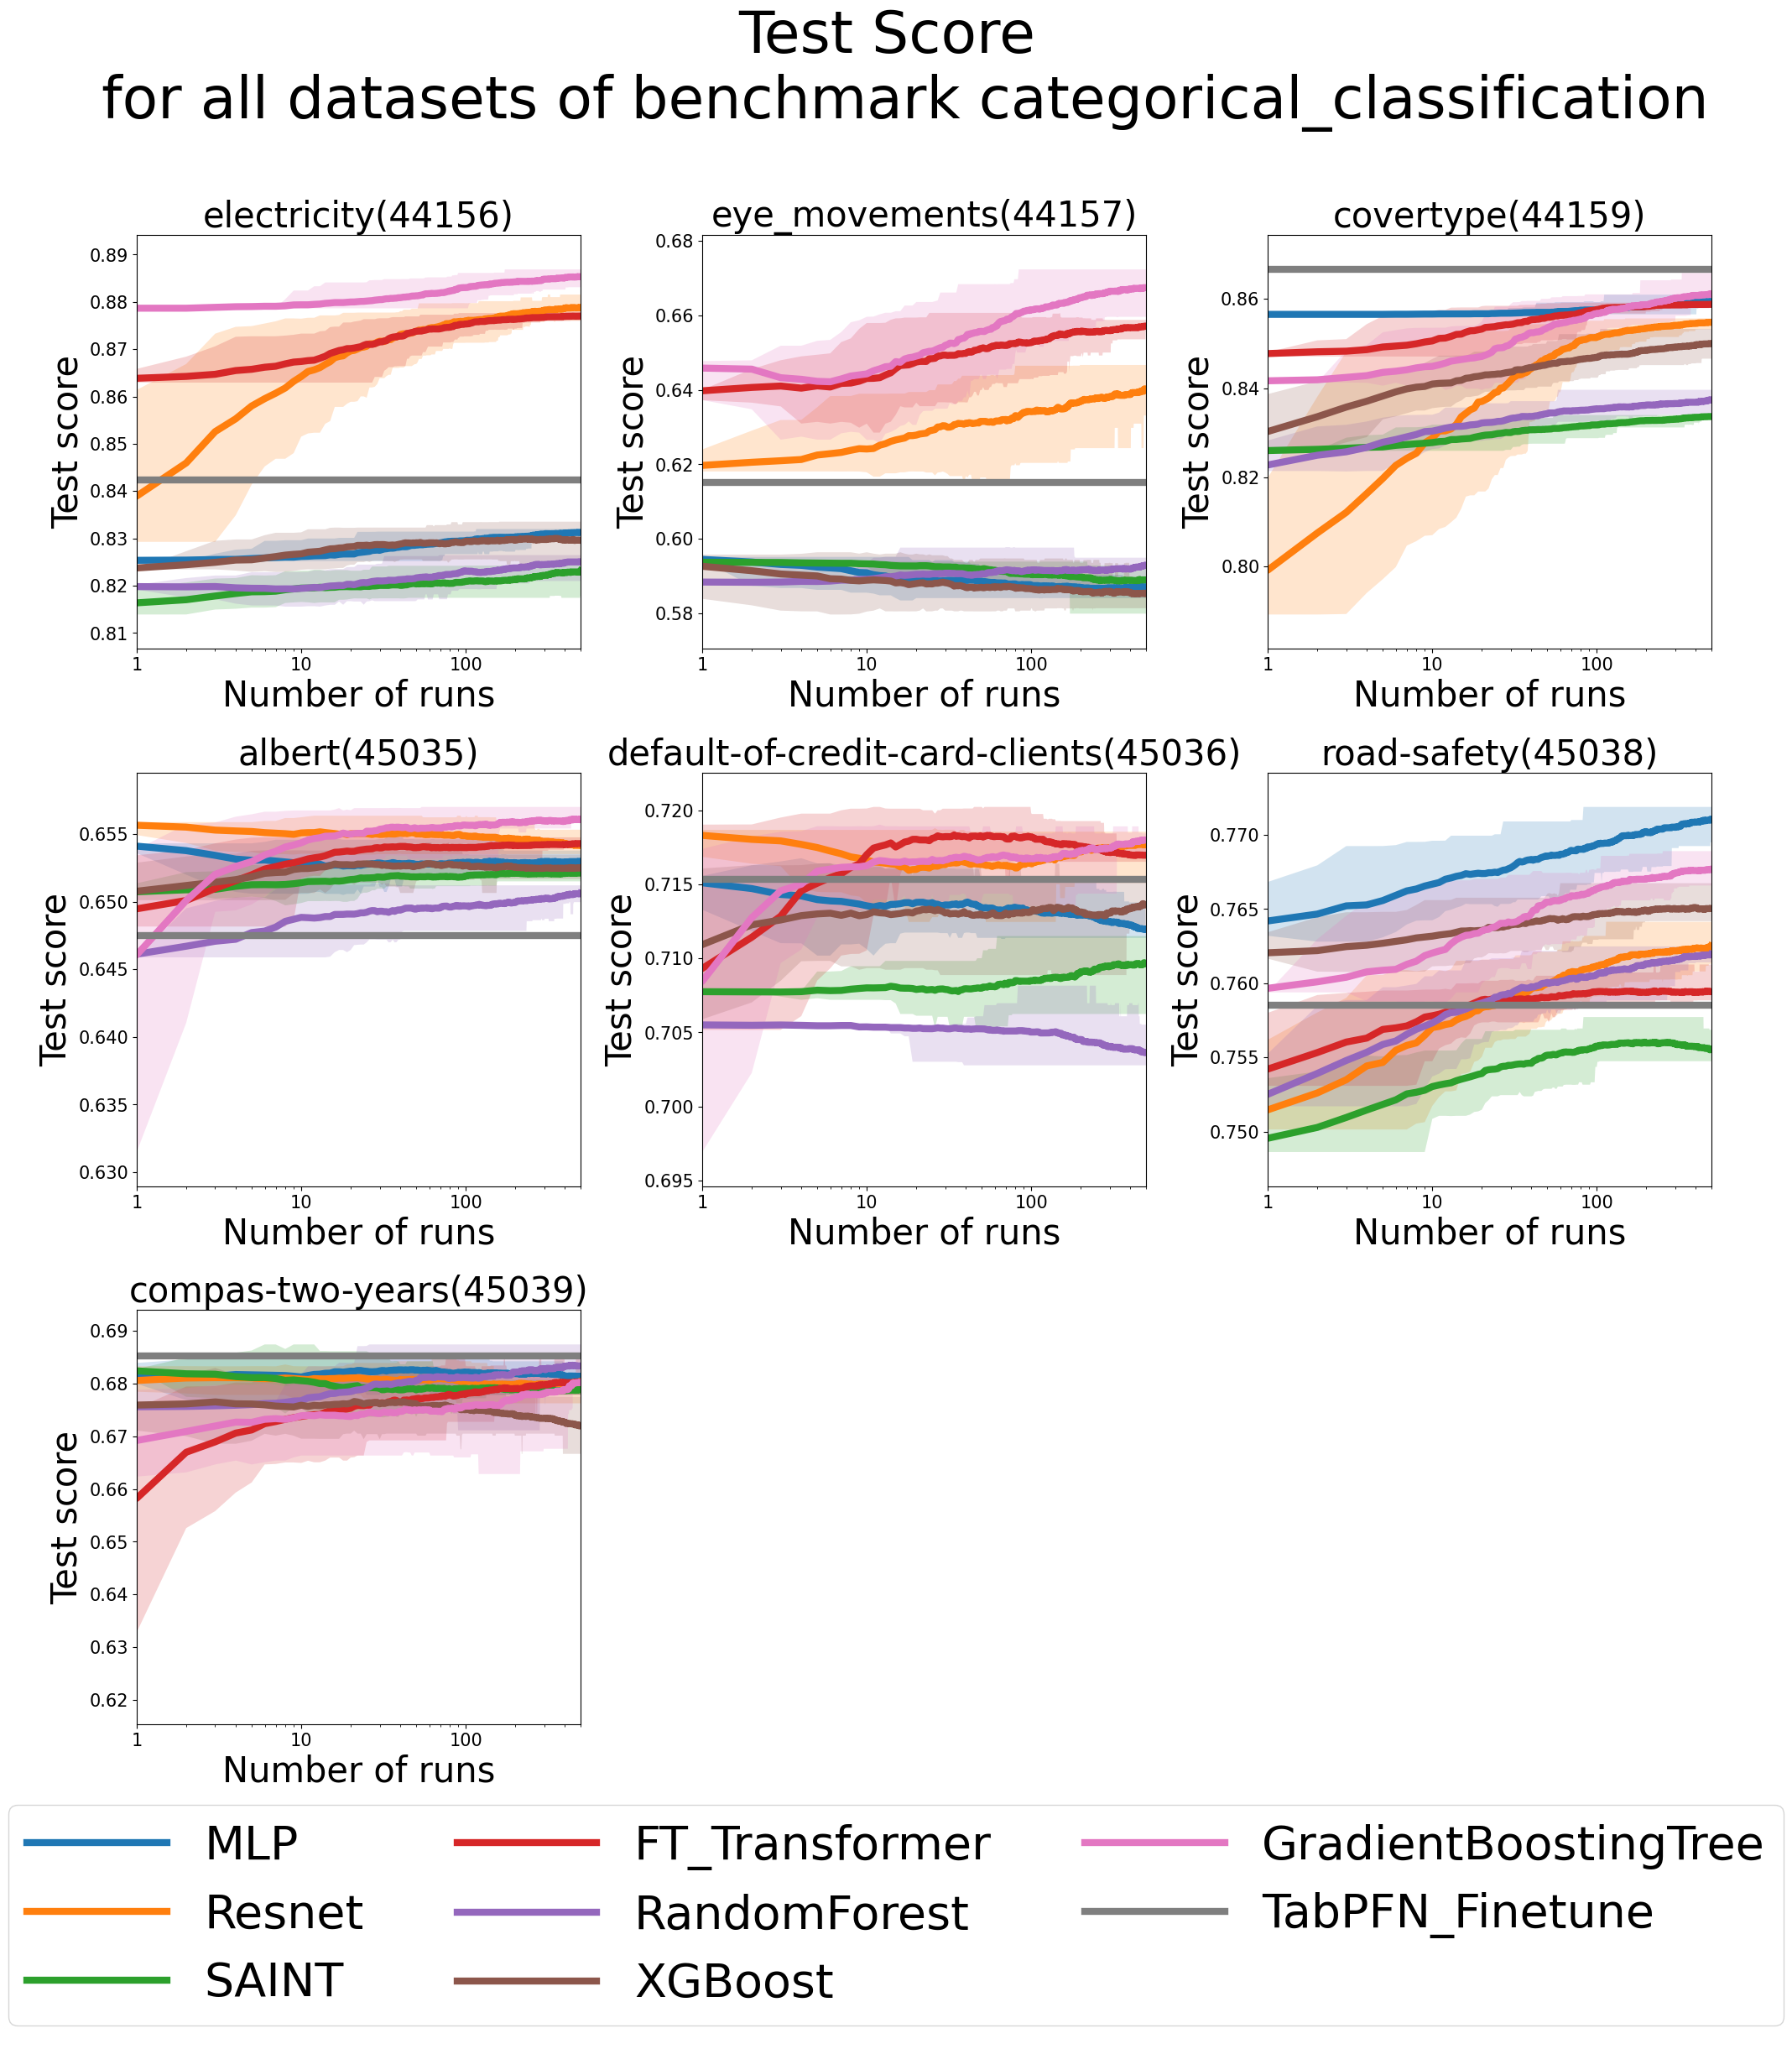

In [4]:
import math
from matplotlib import pyplot as plt
import numpy as np

from tabularbench.sweeps.config_benchmark_sweep import ConfigBenchmarkSweep


models = cfg.config_plotting.benchmark_model_names + [cfg.model_name]
n_dataset_ids = len(cfg.openml_dataset_ids_to_use)

num_horizontal_subplots = math.ceil(math.sqrt(n_dataset_ids))
fig, axs = plt.subplots(nrows=num_horizontal_subplots, ncols=num_horizontal_subplots, figsize=(25, 25), )
axs = axs.flatten()

#remove the last few subplots that we don't need
for i in range(n_dataset_ids, len(axs)):
    fig.delaxes(axs[i])

for dataset_i, (openml_dataset_id, ax) in enumerate(zip(cfg.openml_dataset_ids_to_use, axs)):
    for model_i, model in enumerate(models):

        sequence_mean = plot_data[0, model_i, dataset_i, :]
        sequence_lower_bound = plot_data[1, model_i, dataset_i, :]
        sequence_upper_bound = plot_data[2, model_i, dataset_i, :]

        ax.plot(sequence_mean, label=model, linewidth=6)
        ax.fill_between(
            x=np.arange(len(sequence_mean)), 
            y1=sequence_lower_bound, 
            y2=sequence_upper_bound, 
            alpha=0.2
        )

    dataset_name = cfg.benchmark.openml_dataset_names[cfg.benchmark.openml_dataset_ids.index(openml_dataset_id)]
    ax.set_title(dataset_name + f"({openml_dataset_id})", fontsize=30)
    ax.title.set_size(30)
    ax.set_xlabel("Number of runs")
    ax.xaxis.label.set_size(30)
    ax.set_ylabel("Test score")
    ax.yaxis.label.set_size(30)
    ax.tick_params(axis='both', which='major', labelsize=15)

    min_y = np.min(plot_data[1, :, dataset_i, :])
    max_y = np.max(plot_data[2, :, dataset_i, :])
    spread = max_y - min_y
    min_y = min_y - 0.1 * spread
    max_y = max_y + 0.1 * spread

    ax.set_ylim([min_y, max_y])
    ax.set_xscale('log')
    ax.set_xlim([1, cfg.config_plotting.n_runs])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))


fig.suptitle(f"Test Score \n for all datasets of benchmark {cfg.benchmark.name}", fontsize=50)
fig.tight_layout(pad=2.0, rect=[0.08, 0.12, 0.90, 0.97])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=40, handlelength=3)